In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import warnings

import shap
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as PL
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
import sklearn

In [88]:
# Remember to change back to the file path
# df = pd.read_csv('E:/MSBA/Semester 1/DBA5102 BA Capstone/XAI project/data.csv')
df = pd.read_csv('data.csv')
df.drop(['EmployeeCount', 'EmployeeNumber','Over18','StandardHours'],axis=1,inplace=True)
df.drop(['DailyRate', 'HourlyRate','MonthlyIncome'],axis=1,inplace=True)
df['Education'] = df['Education'].map({1 : 'Below College',2 : 'College',3 : 'Bachelor',4 : 'Master',5 : 'Doctor'})
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].map({1 : 'Low',2 : 'Medium',3 : 'High',4 : 'Very High'})
df['JobInvolvement'] = df['JobInvolvement'].map({1 : 'Low',2 : 'Medium',3 : 'High',4 : 'Very High'})
df['JobSatisfaction'] = df['JobSatisfaction'].map({1 : 'Low',2 : 'Medium',3 : 'High',4 : 'Very High'})
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].map({1 : 'Low',2 : 'Medium',3 : 'High',4 : 'Very High'})
df['PerformanceRating'] = df['PerformanceRating'].map({1 : 'Low',2 : 'Good',3 : 'Excellent',4 : 'Outstanding'})
df['WorkLifeBalance'] = df['WorkLifeBalance'].map({1 : 'Bad',2 : 'Good',3 : 'Better',4 : 'Best'})
df['Attrition'] = np.where(df['Attrition']=='Yes',1,0)
df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,Sales,1,College,Life Sciences,Medium,Female,High,...,Excellent,Low,0,8,0,Bad,6,4,0,5
1,49,0,Travel_Frequently,Research & Development,8,Below College,Life Sciences,High,Male,Medium,...,Outstanding,Very High,1,10,3,Better,10,7,1,7
2,37,1,Travel_Rarely,Research & Development,2,College,Other,Very High,Male,Medium,...,Excellent,Medium,0,7,3,Better,0,0,0,0
3,33,0,Travel_Frequently,Research & Development,3,Master,Life Sciences,Very High,Female,High,...,Excellent,High,0,8,3,Better,8,7,3,0
4,27,0,Travel_Rarely,Research & Development,2,Below College,Medical,Low,Male,High,...,Excellent,Very High,1,6,3,Better,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,Research & Development,23,College,Medical,High,Male,Very High,...,Excellent,High,1,17,3,Better,5,2,0,3
1466,39,0,Travel_Rarely,Research & Development,6,Below College,Medical,Very High,Male,Medium,...,Excellent,Low,1,9,5,Better,7,7,1,7
1467,27,0,Travel_Rarely,Research & Development,4,Bachelor,Life Sciences,Medium,Male,Very High,...,Outstanding,Medium,1,6,0,Better,6,2,0,3
1468,49,0,Travel_Frequently,Sales,2,Bachelor,Medical,Very High,Male,Medium,...,Excellent,Very High,0,17,3,Good,9,6,0,8


In [89]:
#predicted col
predicted = "Attrition"
# Numerical features
numerical = ['Age','DistanceFromHome','MonthlyRate','TotalWorkingYears','NumCompaniesWorked',
'PercentSalaryHike','TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
# Categorical features
categorical = df.columns.difference(numerical+[predicted])

In [90]:
d = dice_ml.Data(dataframe=df, continuous_features=numerical, outcome_name=predicted)

In [91]:
X = df.drop(predicted, axis=1)
y = df[predicted]
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [112]:
numeric_transformer = PL(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore',drop = 'if_binary', sparse =False)

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('smote', SMOTE()),
                      ('classifier', XGBClassifier(objective='binary:logistic',random_state=0,n_jobs=-1,use_label_encoder=False, eval_metric = 'aucpr', tree_method = 'gpu_hist'))])
model = clf.fit(X_train, y_train)

clf = model.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#Accuracy
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('report: ' + str(classification_report(y_test,y_pred)))
#Roc_auc score
print('ROC-AUC score' + str(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))
#Confusion metrics
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

Accuracy Score : 0.8877551020408163
report:               precision    recall  f1-score   support

           0       0.92      0.95      0.94       256
           1       0.58      0.47      0.52        38

    accuracy                           0.89       294
   macro avg       0.75      0.71      0.73       294
weighted avg       0.88      0.89      0.88       294

ROC-AUC score0.798314144736842
Confusion Matrix : 
[[243  13]
 [ 20  18]]


#### Model

In [25]:

XGBoost = XGBClassifier(objective='binary:logistic',random_state=0,n_jobs=-1,use_label_encoder=False, eval_metric = 'aucpr', tree_method = 'gpu_hist')
param ={
    'reg_lambda': [0, 1e-1, 1, 10, 50],
    'n_estimators':range(100,1500,300),
    'eta':np.linspace(0.1,0.7,3),
}
# gs = GridSearchCV(estimator=finalPipe,param_grid=param,scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = 5,verbose = -1)
# finalPipe.set_params(gs.best_params_)

#### Counter-factual

In [32]:
m = dice_ml.Model(model=model, backend='sklearn')
exp_random = dice_ml.Dice(d, m, method="random")
query_instances = X_test[4:6]
dice_exp_random = exp_random.generate_counterfactuals(
        query_instances, total_CFs=5, desired_class="opposite",
        features_to_vary=['BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MonthlyRate', 'OverTime','PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance'])
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

Query instance (original outcome : 0)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,42,Travel_Rarely,Research & Development,1,Master,Life Sciences,Medium,Female,High,1,...,Medium,1,8,5,Better,5,2,1,2,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,Bad,-,-,-,-,1
1,-,-,-,4.0,-,-,-,-,-,-,...,-,-,-,-,Bad,-,-,-,-,1
2,-,-,-,-,-,-,-,-,Low,-,...,-,2,-,-,-,-,-,-,-,1
3,-,-,-,9.0,-,-,-,-,-,-,...,-,-,-,2.0,Bad,-,-,-,-,1
4,-,-,-,6.0,Bachelor,-,-,-,-,-,...,-,-,-,-,Bad,-,-,-,-,1


Query instance (original outcome : 0)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,26,Non-Travel,Research & Development,7,Bachelor,Medical,Very High,Male,High,1,...,High,0,7,5,Better,7,7,5,7,0



Diverse Counterfactual set (new outcome: 1.0)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,-,Travel_Frequently,-,-,Below College,-,-,-,-,-,...,-,-,-,-,Good,-,-,-,-,1
1,-,Travel_Frequently,-,-,-,-,-,-,-,-,...,-,-,-,-,Good,-,-,-,-,1
2,-,-,-,26.0,-,-,-,-,-,-,...,-,-,-,-,Good,-,-,-,-,1
3,-,-,-,-,-,-,-,-,Very High,-,...,-,-,-,-,Bad,-,-,-,-,1
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,1.0,Bad,-,-,-,-,1


In [126]:
def get_feature_names(column_transformer,headers = None):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)

    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans,headers = None):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]
        if type(trans) == OneHotEncoder and headers is not None:
            return [name + "__" + f for f in trans.get_feature_names(headers)]
        else:
            return [name + "__" + f for f in trans.get_feature_names()]

    ### Start of processing
    feature_names = []

    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))


    for name, trans, column, _ in l_transformers:
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans,headers)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans,headers))

    return feature_names
colnames = get_feature_names(transformations,categorical)
# colnames

In [141]:
x = pd.DataFrame(model.steps[0][1].transform(X_train),columns=colnames)
xt = pd.DataFrame(model.steps[0][1].transform(X_test),columns=colnames)
f = lambda x: model.steps[2][1].predict_proba(x)[:,1]
med = x.median().values.reshape((1,x.shape[1]))

In [140]:
explainer = shap.Explainer(f, med)
shap_values = explainer(x)

Permutation explainer:  44%|████▍     | 516/1176 [00:27<00:56, 11.70it/s]


KeyboardInterrupt: 

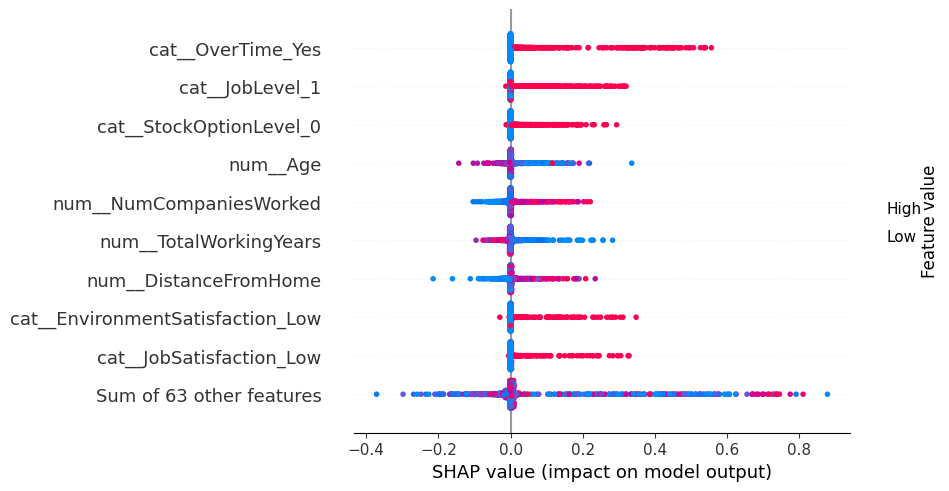

In [129]:
shap.plots.beeswarm(shap_values)

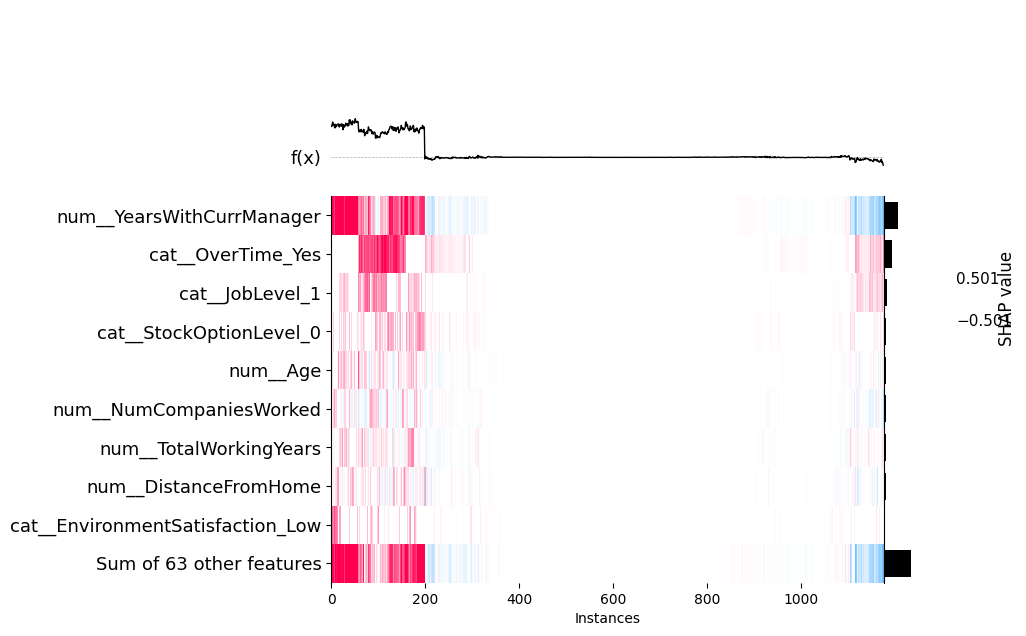

In [130]:
shap.plots.heatmap(shap_values)

In [136]:
shap.initjs()
explainer = shap.KernelExplainer(model.steps[2][1].predict_proba, x)
shap_values = explainer.shap_values(x.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], x.iloc[0,:])

Using 1176 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
